## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Loading datasets

In [2]:
df = pd.read_csv('datasets/tmdb_5000_movies.csv')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [3]:
df.shape

(4803, 20)

## Choosing columns best for recommendation

In [4]:
x = df.iloc[0]
x

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

**Here, I'm choosing genres, keywords, and tagline.**

## Preparing the TFIDF vector

In [5]:
x['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [6]:
gen = json.loads(x['genres'])
gen

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [7]:
' '.join(''.join(n['name'].split()) for n in gen)

'Action Adventure Fantasy ScienceFiction'

In [8]:
def tokens_generator(row):
    out = ''
    
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(n['name'].split()) for n in genres)
    out += genres
    
    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(n['name'].split()) for n in keywords)
    out += keywords

    production_companies = json.loads(row['production_companies'])
    production_companies = ' '.join(''.join(n['name'].split()) for n in production_companies)
    out += production_companies

    return out

In [9]:
tokens_generator(df.iloc[0])

'Action Adventure Fantasy ScienceFictioncultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3dIngeniousFilmPartners TwentiethCenturyFoxFilmCorporation DuneEntertainment LightstormEntertainment'

In [10]:
df['string'] = df.apply(tokens_generator, axis=1)

In [11]:
df['string']

0       Action Adventure Fantasy ScienceFictionculture...
1       Adventure Fantasy Actionocean drugabuse exotic...
2       Action Adventure Crimespy basedonnovel secreta...
3       Action Crime Drama Thrillerdccomics crimefight...
4       Action Adventure ScienceFictionbasedonnovel ma...
                              ...                        
4798    Action Crime Thrillerunitedstates–mexicobarrie...
4799                                       Comedy Romance
4800    Comedy Drama Romance TVMoviedate loveatfirstsi...
4801                                                     
4802    Documentaryobsession camcorder crush dreamgirl...
Name: string, Length: 4803, dtype: object

In [12]:
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['string'])

In [13]:
X = X.toarray()

In [14]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X.shape

(4803, 5000)

## Mapping movie title to index

In [16]:
title = df['title']
title

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: title, Length: 4803, dtype: object

In [17]:
movieidx = pd.Series(df.index, index = df['title'])

In [18]:
movieidx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [19]:
id = movieidx['Home']
id

184

In [20]:
query = X[id]
query

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
query = query.reshape((1,-1))
query

array([[0., 0., 0., ..., 0., 0., 0.]])

## Computing cosine similarity

In [22]:
scores = cosine_similarity(query, X)
scores

array([[0.16380919, 0.03031011, 0.        , ..., 0.02103406, 0.        ,
        0.        ]])

In [23]:
scores = scores.flatten()

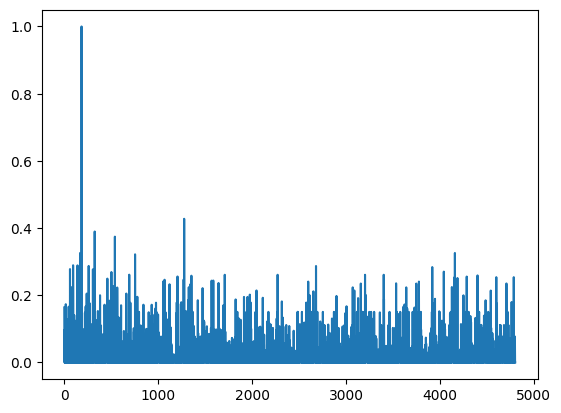

In [24]:
plt.plot(scores);

In [25]:
(-scores).argsort()

array([ 184, 1277,  324, ..., 2101, 3009, 4802], dtype=int64)

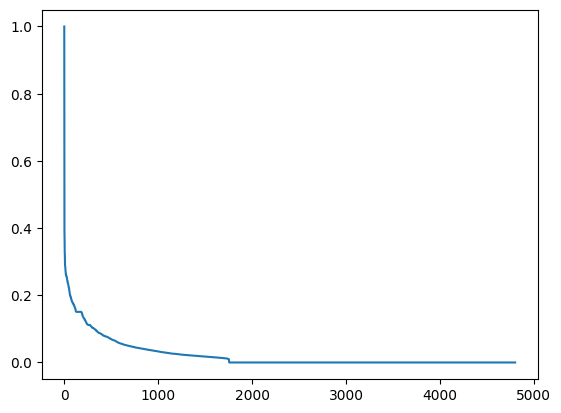

In [26]:
plt.plot(scores[(-scores).argsort()]);

In [27]:
recommended_id = (-scores).argsort()[1:6]
recommended_id

array([1277,  324,  539, 4160,  168], dtype=int64)

In [28]:
df['title'].iloc[recommended_id]

1277                                Delgo
324                 The Road to El Dorado
539                            Titan A.E.
4160                            Northfork
168     Final Fantasy: The Spirits Within
Name: title, dtype: object

## Function to generates recommendations

In [29]:
def recommend(title):
    # get the row in the dataframe for this movie
    try:
        idx = movieidx[title]
    except:
        return "Movie not found on the database!!! Please try other movies."

    if type(idx) == pd.Series:
        idx = idx.iloc[0]
        
    # calculate the pairwise similarities for this movie
    query = X[idx]
    query = query.reshape((1,-1))
    scores = cosine_similarity(query, X)
    
    # currently the array is 1 x N, make it just a 1-D array
    scores = scores.flatten()
    
    # get the indexes of the highest scoring movies
    # get the first 5 recommendations
    # don't return itself!
    recommended_idx = (-scores).argsort()[1:6]
    
    # return the titles of the recommendations
    return df['title'].iloc[recommended_idx]

## Testing the recommendations

In [30]:
recommend('Mortal Kombat')

1611    Mortal Kombat: Annihilation
1670             DOA: Dead or Alive
3613             Digimon: The Movie
2237              Alone in the Dark
1398                      Max Payne
Name: title, dtype: object

In [31]:
recommend('Home')

1277                                Delgo
324                 The Road to El Dorado
539                            Titan A.E.
4160                            Northfork
168     Final Fantasy: The Spirits Within
Name: title, dtype: object

In [32]:
recommend('Final Destination')

1839    Final Destination 3
1789    Final Destination 2
817        American Wedding
1002                The One
701             Cats & Dogs
Name: title, dtype: object

In [33]:
recommend('Dark Knight')

'Movie not found on the database!!! Please try other movies.'

In [34]:
recommend('Runaway Bride')

2931             Corky Romano
2034             Delivery Man
881                   Beloved
3408    Two Lovers and a Bear
2512     Three Men and a Baby
Name: title, dtype: object